### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

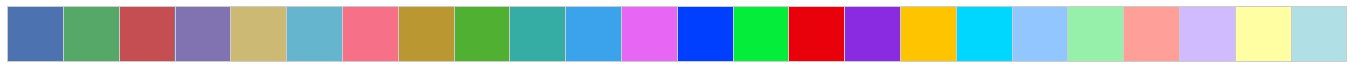

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
import warnings
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import (
    add_mse, add_normed_err, err_cols, add_errs, create_distr, get_dll_pdf, get_dll_cdf, ez,
    add_velocity, vm_cols
)

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [5]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + foi_cols
global_feature_importance = None
train, train_foi = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 63)

(421218, 578782)

Wall time: 9.42 s


In [3]:
# %%time
# closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
# global_foi_train_data = pd.read_pickle(closest_hits_filename).loc[:, xyz_cols + t_cols + dxyz_cols].copy()
# global_foi_train_data.columns = cl_cols
# print(global_foi_train_data.columns)

### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [7]:
# готовим данные для распределения DLL

# либо загружаем уже готовое
closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
# dll_train = pd.read_pickle(closest_hits_filename)
# display(dll_train.columns)

# либо считаем заново
# dll_train, _ = read_train(xy_cols + dx_cols + dy_cols + exy_cols, 10000000)
# dll_train = add_mse(train, [])

# опционально пересчитываем MatchedHits и заменяем ими координаты треков в dll_train, чтобы считать распределение на пересчитанных треках
# dll_train = replace_hits(dll_train, [])

# save DLL
# display(dll_train.columns)
# dll_train.to_pickle(closest_hits_filename)

In [58]:
# если распределение для DLL уже есть сохраненное, то загружаем
cdfs, pdfs, bins = np.load('data/train_cdfs.pkl.npy'), np.load('data/train_pdfs.pkl.npy'), np.load('data/train_bins.pkl.npy')

# либо считаем на основе загруженного dll_train
# cdfs, pdfs, bins = create_distr(dll_train)
# np.save('data/train_cdfs.pkl.npy', cdfs)
# np.save('data/train_pdfs.pkl.npy', pdfs)
# np.save('data/train_bins.pkl.npy', bins)

In [8]:
def add_dll(data, features):
    data[err_cols[1]] = get_dll_pdf(data.loc[:, err_cols[0]], pdfs, cdfs, bins)
    features += err_cols[1:2]
    return data

In [9]:
def fit(train, n_estimators, transformer_cls):
    labels, weights = get_labels_weights(train.loc[:, train_cols])

    # defined much later
    transformer = transformer_cls().fit(train)
    train_values = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=n_estimators, n_jobs=3)
    estimator.fit(train_values, labels, eval_metric=scoring.rejection90_sklearn, sample_weight=weights)
    return transformer, estimator


In [ ]:
# err_cols = ['ErrMSE', 'DLL', 'ErrMSE_2']

# def add_mse_2(data, features):
#     dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
#     D = np.nanmean(dxy**2, axis=1)
    
#     data.loc[:, err_cols[0]] = D
#     features += [err_cols[0]]
#     return data

In [104]:
%%time
def _to_seg_col(col, i):
    return col + ('[%d]' % i)
def _get_col_names(cols):
    return [_to_seg_col(cols[i], j) for j in range(4) for i in range(len(cols))]
def _to_matched_hits_cols(cols):
    return [col.replace('FOI_hits_', '_') for col in cols]

def _prepare_foi(data, cols):
    data = data.loc[:, cols]
    data = data[(-2 <= data['FOI_hits_DT']) & (data['FOI_hits_DT'] <= 4)]
    return data

def _filter_by_t(data, i, j):
    t0 = data.loc[:, _to_seg_col(foi_ts_cols[0], i)]
    t1 = data.loc[:, _to_seg_col(foi_ts_cols[0], j)]
    dt0 = data.loc[:, _to_seg_col(foi_ts_cols[1], i)]
    dt1 = data.loc[:, _to_seg_col(foi_ts_cols[1], j)]
    mask = (t0 <= t1) & (t0 <= t1 + dt1) & (t0 + dt0 <= t1) & (t0 + dt0 <= t1 + dt1)
    return data.loc[mask | (t0.isna()) | (t1.isna()), :]


def _filter_by_edx2(data, edata, i):
    seg = data.loc[data['FOI_hits_S'] == i%4, [foi_xyz_cols[i//4], foi_dxyz_cols[i//4]]]
    seg = seg.merge(edata.loc[:, [exy_cols[i], edxy_cols[i]], how='inner', left_index=True, right_index=True)
    
    dx = data.loc[:, _to_seg_col(foi_dxyz_cols[i//4], i%4)].values
    ex = seg.loc[:, exy_cols[i]].values
    edx = np.sqrt(seg.loc[:, edxy_cols[i]].values)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mask = (x - dx <= ex + edx) & (x + dx >= ex - edx)
        return data.loc[np.isnan(x) | mask, :]

def _filter_by_edx(data, i):
    x = data.loc[:, _to_seg_col(foi_xyz_cols[i//4], i%4)].values
    dx = data.loc[:, _to_seg_col(foi_dxyz_cols[i//4], i%4)].values
    ex = data.loc[:, exy_cols[i]].values
    edx = np.sqrt(data.loc[:, edxy_cols[i]].values)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mask = (x - dx <= ex + edx) & (x + dx >= ex - edx)
        return data.loc[np.isnan(x) | mask, :]

def _merge_hits(data):
    seg_col = foi_ts_cols[2]
    data.astype({seg_col: np.int8}, copy=False)
    segs = [data.loc[data[seg_col] == i, :] for i in range(4)]
    lhalf = segs[0].merge(segs[1], how='outer', left_index=True, right_index=True, suffixes=('[0]', '[1]'))
    lhalf = _filter_by_t(lhalf, 0, 1)
    
    rhalf = segs[2].merge(segs[3], how='outer', left_index=True, right_index=True, suffixes=('[2]', '[3]'))
    rhalf = _filter_by_t(rhalf, 2, 3)
    
    result = lhalf.merge(rhalf, how='outer', left_index=True, right_index=True)
    result = _filter_by_t(result, 0, 2)
    result = _filter_by_t(result, 0, 3)
    result = _filter_by_t(result, 1, 2)
    result = _filter_by_t(result, 1, 3)
    return result

def _get_dist(data):
    deltas = np.empty((len(data), 4), dtype=np.float)
    for i in range(4):
        xy_cols = [_to_seg_col(col, i) for col in foi_xyz_cols[:2]]
        dxy_cols = [_to_seg_col(col, i) for col in foi_dxyz_cols[:2]]
        x, dx, ex = data[xy_cols[0]].values, data[dxy_cols[0]].values, data[exy_cols[i]].values
        y, dy, ey = data[xy_cols[1]].values, data[dxy_cols[1]].values, data[exy_cols[i+4]].values
        erx = (x - ex) / dx
        ery = (y - ey) / dy
        deltas[:, i] = erx**2 + ery**2
        
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return np.nanmean(deltas, axis=1)

def _append_empty_hits(data):
    ids = data.index.unique()
    segs = np.tile(np.arange(1, 4), len(ids))
    ids = np.repeat(ids, 3)
    
    nans = pd.DataFrame(index=ids, columns=data.columns)
    nans['FOI_hits_S'] = segs
    return pd.concat((data, nans), axis=0)

def match_hits(data, data_foi):
    d_col = 'D2'
    e_cols = exy_cols + edxy_cols + (train_cols[:1] if train_cols[0] in data.columns else [])
    disp_cols = foi_ts_cols[:-1]
    
    dt = _prepare_foi(data_foi, foi_cols)
    dt = _append_empty_hits(dt)
    
    dt = _merge_hits(dt)
    print(data.shape, data_foi.shape, dt.shape)
    
    dt = dt.merge(data.loc[:, e_cols], how='outer', left_index=True, right_index=True)
#     display(dt)
    for i in range(8):
        dt = _filter_by_edx(dt, i)
    dt.loc[:, d_col] = _get_dist(dt)
    
    display(dt.shape)
    dt = dt.sort_values(by=['id', d_col])
    dt = dt[~dt.index.duplicated(keep='first')]
    display(dt[e_cols[-1:] + [d_col] + _get_col_names(disp_cols)].head(10))
#     display(dt)
    dt = dt.loc[:, _get_col_names(foi_cols) + [d_col]]
    dt.columns = _to_matched_hits_cols(dt.columns)
    return dt

def match_hits_batched(data, data_foi):
    batch_size = 40000
    nbatches = (len(data.index) - 1) // batch_size + 1
    result = []
    for batch in np.array_split(data, nbatches):
        batch_foi = data_foi.loc[data_foi.index.isin(batch.index), :]
        result.append(match_hits(batch, batch_foi))
        
    return pd.concat(result, axis=0, ignore_index=False)

dt, dt_foi = read_train(used_cols, 10000)
_ = match_hits(dt, dt_foi)

(10000, 63) (89288, 9) (81546, 36)


(18149, 54)

,label,D2,FOI_hits_T[0],FOI_hits_DT[0],FOI_hits_T[1],FOI_hits_DT[1],FOI_hits_T[2],FOI_hits_DT[2],FOI_hits_T[3],FOI_hits_DT[3]
id,,,,,,,,,,
0,1,0.354919,3.0,0.0,NaN,NaN,7.0,0.0,NaN,NaN
1,1,1.086436,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.455761,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.163635,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1.053214,6.0,-2.0,6.0,0.0,NaN,NaN,NaN,NaN
5,1,0.237232,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,0,1.009685,7.0,0.0,NaN,NaN,7.0,0.0,NaN,NaN
7,1,2.172001,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN
8,1,0.217390,6.0,1.0,NaN,NaN,9.0,0.0,NaN,NaN


Wall time: 1.14 s


In [209]:
%%time
# global_matched_hits_train = match_hits_batched(train, train_foi)

Wall time: 0 ns


In [55]:
def add_matched_hits_coses(data, features):
    def get_layer_coords(data, i):
        return data[['_X[%d]'%i, '_Y[%d]'%i, '_Z[%d]'%i]].values
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        cosines = dot(L1, L2) / L1_norm / L2_norm
        return np.clip(cosines, -1., 1.)
    def get_zero_point(data):
        layers = [data[[ex_cols[i], ey_cols[i], z_cols[i]]].values for i in range(2)]
        d = layers[1] - layers[0]
        return d
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    layers[0] = get_zero_point(data)
    cols = ['_DAngle[%d]'%i for i in range(1, 4)]
    
    for i in range(3):
        cur_layer = layers[i]
        next_layer = layers[i+1]
        nan_mask = np.isnan(next_layer[:, 0])
        next_layer[nan_mask, :] = cur_layer[nan_mask, :]
        
        cosines = get_cosine_dist(cur_layer, next_layer, norm(cur_layer), norm(next_layer))
        degrees = to_degrees(cosines)
        cosines[nan_mask] = np.NaN
        degrees[nan_mask] = np.NaN
        data[cols[i]] = degrees
        
    features += cols
    return data

In [24]:
def add_matched_hits(data, features):
    global_matched_hits = global_matched_hits_train if train_cols[0] in data.columns else global_matched_hits_test
    for col in global_matched_hits.columns:
        data.loc[:, col] = global_matched_hits.loc[data.index.values, col].values
    features += list(global_matched_hits.columns)
    return data

def add_matched_hits_online(data, features):
    data_foi = train_foi if train_cols[0] in data.columns else test_foi
    matched_hits = match_hits_batched(data, data_foi)
    for col in matched_hits.columns:
        data.loc[:, col] = matched_hits.loc[data.index.values, col].values
    features += list(matched_hits.columns)
    return data

In [56]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features):
    if global_feature_importance is None:
        return features
    fscore = global_feature_importance
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.006]
    return features

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + mom_cols + hit_type_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + dxyz_cols
        features = filter_unimportant_features(features)
        self.origin_features = features.copy()

#         data = replace_hits(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
        add_velocity(data, features)
        add_matched_hits_online(data, features)
        add_matched_hits_coses(data, features)
        
#         filter_data(data)
        if not features:
            raise('no features')
    
        features = filter_unimportant_features(features)
        self.new_features = features[len(self.origin_features):]
        self.features = self.origin_features + self.new_features
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.773299,0.767488,0.875085,0.817760,0.804064,0.749836,0.114624
std,0.010397,0.008934,0.006746,0.008009,0.009356,0.100139,0.006422
min,0.766277,0.761282,0.870934,0.812425,0.797484,0.651822,0.108754
25%,0.767327,0.762369,0.871193,0.813155,0.798709,0.698768,0.111194
50%,0.768377,0.763455,0.871451,0.813886,0.799933,0.745714,0.113634
75%,0.776810,0.770591,0.877160,0.820428,0.807354,0.798843,0.117559
max,0.785243,0.777727,0.882869,0.826970,0.814775,0.851972,0.121483


Wall time: 14.8 s


### Test theory

In [59]:
%%time
global_feature_importance = None
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.788080,0.781309,0.879747,0.827606,0.821922,0.720457,0.084105
std,0.002731,0.003410,0.002254,0.001896,0.003111,0.025131,0.001437
min,0.785250,0.778058,0.876427,0.825655,0.818349,0.697742,0.081780
25%,0.786500,0.779018,0.879367,0.826479,0.820074,0.707760,0.083886
50%,0.786700,0.779592,0.879453,0.826881,0.821024,0.715219,0.084328
75%,0.790400,0.784095,0.881010,0.828632,0.824148,0.718473,0.085086
max,0.791550,0.785781,0.882480,0.830384,0.826016,0.763091,0.085444


Wall time: 4min 2s


In [65]:
global_feature_importance = feature_importance.copy()
sum(global_feature_importance.score > .01)

30

In [61]:
display(global_feature_importance)

,score
ErrMSE,0.122765
PT,0.069130
DAngle[1],0.046484
NShared,0.046484
DAngle[3],0.035757
DAngle[2],0.032181
NErr_X[0],0.032181
MT,0.029797
ncl[0],0.028605
ncl[2],0.027414


### Get result

In [48]:
test, test_foi = read_pub_test(used_cols)
# global_matched_hits_test = match_hits_batched(test, test_foi)

In [67]:
%%time
_t = global_feature_importance
# global_feature_importance = None
fit_predict_save(sample(train, 100000), test, "out/10_matched_hits_1seg_cos_d2_importance_100.csv", n_estimators=120, transformer_cls=DataTransformer)
global_feature_importance = _t

Wall time: 2min 21s


In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [139]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [5]:
from transformers.cosine import da_cols
from transformers.err import err_cols, nerr_xy_cols

In [99]:
def to_closest_cols(cols):
    return ['Cl_' + col for col in cols]

cl_xyz_cols = to_closest_cols(xyz_cols)
cl_t_cols = to_closest_cols(t_cols)
cl_dxyz_cols = to_closest_cols(dxyz_cols)
cl_cols = cl_xyz_cols + cl_t_cols + cl_dxyz_cols

def fill_global_closest_matched_hits(data, data_foi):
    data.loc[:, 'id'] = data.index.values
    exy = data.loc[:, exy_cols]
    data_foi = data_foi.astype({foi_ts_cols[2]: np.int16})
    join = data_foi.join(exy, on='id', how='inner')
    for i in range(4):
        mask = join[foi_ts_cols[2]] == i
        slc = join.loc[mask, ['id', foi_ts_cols[2], exy_cols[i], exy_cols[i+4], foi_xyz_cols[0], foi_xyz_cols[1]]]
        dx = slc.loc[:, exy_cols[i]].values - slc.loc[:, foi_xyz_cols[0]].values
        dy = slc.loc[:, exy_cols[i+4]].values - slc.loc[:, foi_xyz_cols[1]].values
        join.loc[mask, 'D2'] = dx**2 + dy**2
        
    res = join.sort_values(by=['id', foi_ts_cols[2], 'D2'])
    res = res.drop_duplicates(subset=['id', foi_ts_cols[2]])
        
    subcols = foi_xyz_cols + foi_ts_cols[:1] + foi_dxyz_cols
    nsubcols = len(subcols)
    for i, col in enumerate(cl_cols):
        mask = res[foi_ts_cols[2]] == (i % 4)
        indices = res.loc[mask, 'id']
        data.loc[indices, col] = res.loc[mask, subcols[i // 4]].values
    return data

def add_cl_hits(data, features):
    global_foi_data = global_foi_train_data if train_cols[0] in data.columns else global_foi_test_data
    for col in cl_cols:
        data.loc[:, col] = global_foi_data.loc[data.index.values, col].values        
    features += cl_cols
    return data

def add_cl_mse(data, features):
    dxy = (data.loc[:, cl_xyz_cols[:8]].values - data.loc[:, exy_cols].values) / data.loc[:, cl_dxyz_cols[:8]].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    col = 'cl_' + err_cols[0]
    data.loc[:, col] = D
    features += [col]
    return data

def replace_hits(data, features):
    global_foi_data = global_foi_train_data if train_cols[0] in data.columns else global_foi_test_data
    for col in cl_cols:
        data.loc[:, col[3:]] = global_foi_data.loc[data.index.values, col].values
    return data

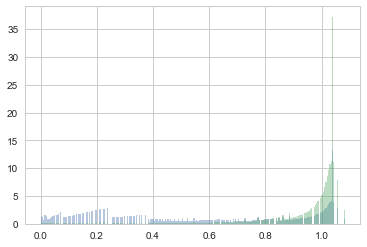

In [133]:
def plot_dll(data):
    DLL = get_dll_cdf(data, pdfs, cdfs, bins)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        _ = sns.distplot(DLL, bins=len(bins), kde=False, norm_hist=True)

dts = [dt.loc[:, err_cols[0]] for dt in split_classes(dll_train)]
plot_dll(dts[0].values)
plot_dll(dts[1].values)
# plot_dll(dll_train.loc[:, err_cols[0]].values)

In [110]:
nrows = 1000000
train, train_foi = read_train(foi_ts_cols, nrows)

ts = train_foi[foi_ts_cols[0]].values
dts = train_foi[foi_ts_cols[1]].values

DescribeResult(nobs=8637411, minmax=(1.0, 15.0), mean=6.558298, variance=11.261726, skewness=0.4544934630393982, kurtosis=-0.38207915523810065)
DescribeResult(nobs=8637411, minmax=(-14.0, 15.0), mean=2.0806417, variance=20.990376, skewness=0.5840174555778503, kurtosis=0.9575571200203767)


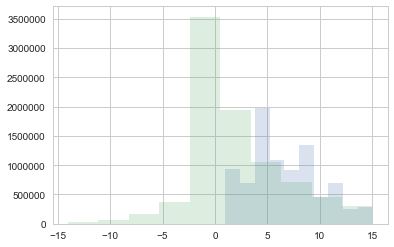

In [111]:
plt.hist(ts, alpha=0.2)
plt.hist(dts, alpha=0.2)

print(sts.describe(ts))
print(sts.describe(dts))

In [129]:
print(np.quantile(dts, (0.08, 0.8)))

[-2.  6.]
